# 데이터 확인

In [5]:
import pandas as pd

data = pd.read_csv("/content/sample_data/train.csv")  # 데이터 파일을 읽어옴
data.head()  # 5개의 데이터를 표시

,Date,Open,High,Low,Volume,Close
0,2015-12-16,120,123,118,13181000,123
1,2015-12-17,124,126,122,17284900,123
2,2015-12-18,121,122,118,17948100,118
3,2015-12-21,120,120,116,11670000,117
4,2015-12-22,117,117,115,9689000,116


# 데이터셋 전체 확인

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    967 non-null    object
 1   Open    967 non-null    int64 
 2   High    967 non-null    int64 
 3   Low     967 non-null    int64 
 4   Volume  967 non-null    int64 
 5   Close   967 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 45.5+ KB


# 데이터의 분포 확인

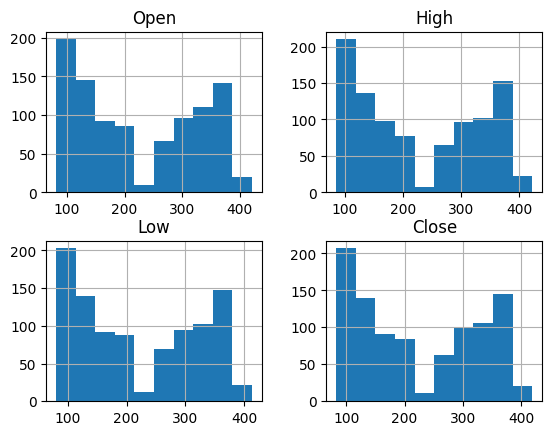

In [7]:
import matplotlib.pyplot as plt

data_used = data.iloc[:, 1:4]  # 개장가, 최고가, 최저가 추가
data_used["Close"] = data["Close"]  # 종가 추가
hist = data_used.hist()
plt.show()

- 값의 범위가 100부터 400까지 넓게 형성되어 있음
- 출력값의 범위가 커지면 오차의 범위도 커지고, 오차가 커지면 역전파되는 기울기도 커지기 때문에 안좋음
- 따라서 값의 범위를 0부터 1사이로 정규화 하는 것이 좋아보임 (이를 최소-최대 정규화라고 함)
- 이상치가 있을 때는 사용하지 않는 게 좋음

# 넷플릭스 데이터셋 정의

- Dataset() 객체는 함수 3개를 제공함
- __init__() 함수는 데이터셋 초기화를, __len__()은 데이터 개수를, __getitem__()은 특정 요소를 불러옴

In [8]:
import numpy as np

from torch.utils.data.dataset import Dataset


class Netflix(Dataset):  # ❶ 클래스 선언
    def __init__(self):
        self.csv = pd.read_csv("/content/sample_data/train.csv")        # ❷ 데이터 읽기

        # 입력 데이터 정규화
        self.data = self.csv.iloc[:, 1:4].values   # ❸ 종가를 제외한 데이터
        self.data = self.data / np.max(self.data)  # ➍ 0과 1 사이로 정규화
        # 해당 데이터셋에서 가장 큰 값을 반환하고
        # 이 값으로 모든 값을 나누고 데이터를 업데이트 함

        # ➎ 종가 데이터 정규화
        self.label = data["Close"].values
        self.label = self.label / np.max(self.label)

    def __len__(self):
        return len(self.data) - 30 # ❶ 사용 가능한 배치 개수
        # 입력 데이터는 i 번째 날부터 i+29번째 날까지
        # 종가 데이터는 i+30번째 날의 종가 데이터만 불러옴

    def __getitem__(self, i):
      # self.data 안에는 전체 데이터가 들어 있기 때문에 호출할 때마다 30개씩 불러와야 함
      # 반면 정답 데이터 안에는 입력으로 읽어들인 30개 시점 바로 뒤에 오는 값을 읽어오면 됨
        data = self.data[i:i+30] # ❶ 입력 데이터 30일치 읽기
        label = self.label[i+30] # ❷ 종가 데이터 30일치 읽기

        return data, label


# RNN 클래스 정의하기

In [9]:
import torch
import torch.nn as nn


class RNN(nn.Module):
   def __init__(self):
       super(RNN, self).__init__()

       self.rnn = nn.RNN(input_size=3, hidden_size=8, num_layers=5,
                         batch_first=True)  # ❶ RNN층의 정의
      # input_size는 입력 텐서의 특징 개수를 의미합니다.
      # hidden_size는 RNN층에서 각 시점에서의 차원을 의미합니다.
      # num_layers는 쌓을 RNN 층을 의미합니다. (보통 3이나 5를 사용합니다)
      # batch_first는 배치 차원이 가장 앞으로 오게 하는 것을 의미합니다.

       # ❷ 주가를 예측하는 MLP층 정의
       self.fc1 = nn.Linear(in_features=240, out_features=64)
       self.fc2 = nn.Linear(in_features=64, out_features=1)

       self.relu = nn.ReLU() # 활성화 함수 정의

   def forward(self, x, h0):
       x, hn = self.rnn(x, h0)  # ❶ RNN층의 출력
       # 파이토치의 RNN층은 출력값이 2개입니다.
       # 첫 번째 출력인 x는 마지막 RNN층의 은닉 상태를,
       # 두 번째 출력인 hn은 모든 RNN층의 은닉 상태를 반환
       # 시계열 차원을 제거해서 MLP의 입력으로 사용하도록 텐서의 모양을 변경해줘야 함

       # ❷ MLP층의 입력으로 사용될 수 있도록 모양 변경
       x = torch.reshape(x, (x.shape[0], -1))
       # reshape(tensor, shape)
       # tensor를 shape 모양이 되도록 변환

       # MLP 층을 이용해 종가를 예측
       x = self.fc1(x)
       x = self.relu(x)
       x = self.fc2(x)

       # 예측한 종가를 1차원 벡터로 표현
       x = torch.flatten(x)

       return x

# 모델과 데이터셋 정의

In [10]:
import tqdm

from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

model = RNN().to(device)  # 모델의 정의
dataset = Netflix()  # 데이터셋의 정의

# 데이터로더 정의

In [11]:
loader = DataLoader(dataset, batch_size=32)  # 배치 크기를 32로 설정

# 최적화 정의

In [12]:
optim = Adam(params=model.parameters(), lr=0.0001) # 사용할 최적화를 설정

# 학습 루프 정의

In [13]:
for epoch in range(200):
   iterator = tqdm.tqdm(loader)
   for data, label in iterator:
       optim.zero_grad()

       # ❶ 초기 은닉 상태
       # 은닉층의 모양은 RNN은 (은닉층 개수, 배치 크기, 출력의 차원)으로 구성
       h0 = torch.zeros(5, data.shape[0], 8).to(device)
       # zeros(A) : A 모양을 갖는 텐서를 반환, 이 때 모든 요소는 0으로 채워짐

       # ❷ 모델의 예측값
       pred = model(data.type(torch.FloatTensor).to(device), h0)

       # ❸ 손실의 계산
       loss = nn.MSELoss()(pred,
                           label.type(torch.FloatTensor).to(device))
       loss.backward()  # 오차 역전파
       optim.step()  # 최적화 진행

       iterator.set_description(f"epoch{epoch} loss:{loss.item()}")

torch.save(model.state_dict(), "./rnn.pth")  # 모델 저장

epoch199 loss:0.002451858716085553: 100%|██████████| 30/30 [00:00<00:00, 97.22it/s]


# 모델 성능 평가하기

In [14]:
import matplotlib.pyplot as plt

loader = DataLoader(dataset, batch_size=1)  # 예측값을 위한 데이터 로더

preds = []  # 예측값들을 저장하는 리스트
total_loss = 0

with torch.no_grad():
   # 모델의 가중치 불러오기
   model.load_state_dict(torch.load("rnn.pth", map_location=device))

   for data, label in loader:
       h0 = torch.zeros(5, data.shape[0], 8).to(device)  # ➊초기 은닉상태 정의

       # 모델의 예측값 출력
       pred = model(data.type(torch.FloatTensor).to(device), h0)
       preds.append(pred.item())  # ➋예측값을 리스트에 추가
       loss = nn.MSELoss()(pred,
                           label.type(torch.FloatTensor).to(device))  # 손실계산
       total_loss += loss/len(loader)  # ➌손실의 평균치 계산

total_loss.item()

0.0032713026739656925

# 그림으로 확인하기

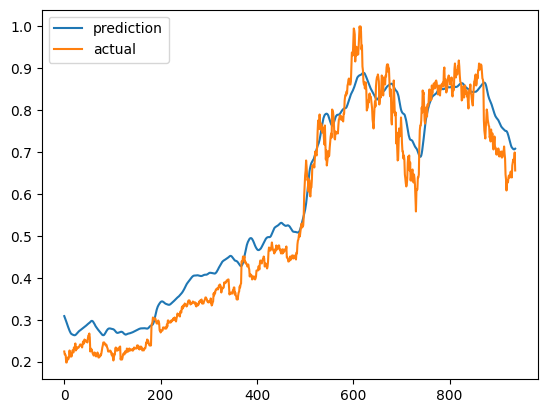

In [15]:
plt.plot(preds, label="prediction")
plt.plot(dataset.label[30:], label="actual")
plt.legend()
plt.show()